In [222]:
%matplotlib inline
import pyvap as pv # custom-built package
import pandas as pd
from copy import deepcopy, copy
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import logging
from scipy.special import lambertw
from scipy import optimize, stats
from scipy.constants import pi, k, R, N_A
import random
from scipy.optimize import fsolve

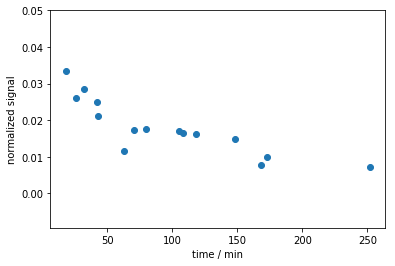

In [223]:
# import makefigs, params
os.chdir('C:\\Users\\joh3146\\Documents\\research\\bdpaper\\')
import makefigs
makefigs.init_pars(os.path.join("params.yaml"))

# import data from bd-as-all
DATA_PATH = os.path.join(os.path.curdir, "data", "bd-as-all.csv")
df = pd.read_csv(DATA_PATH)


# import filtered data, i.e., dry flow measurements only
p = makefigs.PARS
df_hum = makefigs.filterdata(df, p['bd_hg_humid'])[1]
df_hum.d = makefigs.calcdiam(df_hum)

# plot data of interest
fig, ax = plt.subplots()
ax.scatter(df_hum.trapped, df_hum.n85)
ax.set_xlabel('time / min')
ax.set_ylabel('normalized signal');

In [230]:
def extractvp_validate(df, p, model_params_key, filter_key, compound_key, labelcolor):
    data = makefigs.filterdata(df, p[filter_key])[1]
    
    # extract model_params from yaml file
    model_params = p[model_params_key]

    # if humid data, add dry data before 5 min as calibration data
    if (filter_key == 'bd_hg_humid'):
        dry_data = makefigs.filterdata(df, p['bd_hg_dry'])[1]
        data = data.append(dry_data[dry_data.trapped<=5])
    else: pass
    
    # set inputs to extract_vp, fit_pvap
    cal_data_query = "trapped<={}".format(model_params['cal_data_time'])
    cal_data = data.query(cal_data_query)['n85'] # calibration data

    init_comp = makefigs.calc_init_bd10peg20_comp() # initial composition
    cmpds = [p[x] for x in model_params['cmpds']]
    r_range = (model_params['r_dry_min'], model_params['r_dry_max']) # bootstrap?
    xh2o_range = (model_params['xh2o_min'], model_params['xh2o_max'])
    temp_range = (model_params['temp_min'], model_params['temp_max'])
    
    # need to get time-averaged radius for extractvp
    def r_avg(r0, t):
        A = 0.1*r0 # "loss of radius"
        b = np.max(data.trapped)*(1-(1/np.e)) # characteristic time
        C = 0.9*r0 # radius without butenedial
        L = np.max(data.trapped) # integration period

        return (A / (b*L)) * (1 - np.exp(-b*L)) + C # mean value theorem derived
        
    r_range_exvp = (r_avg(model_params['r_dry_min'], np.max(data.trapped)), 
                    r_avg(model_params['r_dry_max'], np.max(data.trapped)))

    # run extract vp and store outputs in dict_exvp
    exvp = makefigs.extractvp(
        cmpds, init_comp, model_params['value_idx'],
        model_params['norm_idx'], data['trapped'],
        data['n85'], cal_data, r_range_exvp, temp_range,
        makefig=False, has_water=True, xh2o=xh2o_range,
        analyze_uncertainty=True, N=1000)
    
    # redefine function
    def f_maxwellflux(x, coefs):
        a = coefs[0]
        b = coefs[1]
        c = coefs[2]
        C0 = coefs[3]
        return (b/c) * (np.real(lambertw(c*np.exp((a*x + C0)/b)/b)))

    # store coefficients in array accounting for 1 standard deviation changes in vapor pressure
    coefs_upper = copy(exvp['coef_mean'])
    coefs_lower = copy(exvp['coef_mean'])

    coefs_upper[0] = exvp['coef_mean'][0]*(1+exvp['vp_std']*exvp['vp_mean']**-1)
    coefs_lower[0] = exvp['coef_mean'][0]*(1-exvp['vp_std']*exvp['vp_mean']**-1)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.fill_between(
        exvp['t_a'], f_maxwellflux(exvp['t_a'], coefs_upper), f_maxwellflux(exvp['t_a'], coefs_lower),
        alpha=0.1, color=labelcolor, label='uncertainty window')

    ax.plot(exvp['t_a'], exvp['n_a'], color=labelcolor,
             label='Closed form solution (pvap_mean = %.1e +/- %.1e)' % (exvp['vp_mean'], exvp['vp_std']))

    ax.scatter(data.trapped, data.n85*exvp['scale_mean'], color=labelcolor, label='Observations')
    ax.set_xlabel("time in EDB / min")
    ax.set_ylabel(r"$\mathrm{n_{BD} / n_{PEG-6}}$")
    ax.legend()
    
    plot_str = compound_key + '.png'
    fig.savefig(plot_str, bbox_inches='tight', dpi=300)
    return fig, ax

running 1000 simulations
simulation 0


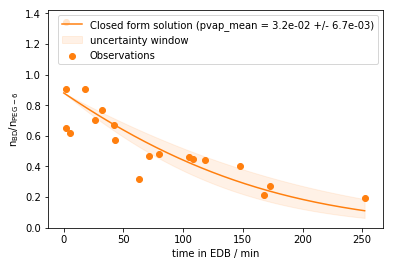

In [231]:
bd_hum = extractvp_validate(df, p, 'bd_humid_model_params', 'bd_hg_humid', 'bd_humid', 'C1')

In [226]:
# scale from mass spec to mol/mol_internalstandard
def ms_to_molratio(cmpds, comp, value_idx, norm_idx, cal_data):
    '''scale normalized mass spec signal data to normalized mole ratio.
    
    obtain mean and std of scaling factor via bootstrapping.
    '''
    # Bootstrap to get sample statistics (data constrained)
    def get_bootstrap_sample(dataset):
        bootstrap_sample = np.random.choice(dataset, size=len(dataset))
        
        return bootstrap_sample

    def perform_bootstrap(dataset):
        n = 10000
        samples = np.empty(shape=(n,len(dataset)))

        for i in range(0,n):
            samples[i] = get_bootstrap_sample(dataset)
        
        return samples

    ncal_samples = perform_bootstrap(cal_data)
    ncal_means = np.mean(ncal_samples, axis=0)
    ncal_avgmean = np.mean(ncal_means)
    ncal_stdmean = np.std(ncal_means)
    # relative standard deviation
    ncal_rsd = ncal_stdmean / ncal_avgmean

    # experimental molar ratio relative to internal standard
    moleratio = comp[value_idx] / comp[norm_idx]
    # Get conversion factor: (mole ratio) / (bootstrapped MS signal ratio)
    # defined as distribution from bootstrapping with mean and std
    scale_avg = moleratio / ncal_avgmean
    scale_std = ncal_rsd * scale_avg

    return scale_avg, scale_std

def extractvp_new(cmpds, comp, value_idx, norm_idx, tobs, nobs, cal_data, r, temp,
              makefig, has_water, xh2o, analyze_uncertainty, store_vps, N=10000):
    '''Extract vapor pressure of analyte compound.

    Use normalized mass spectrum observations.

    Parameters
    ----------
    cmpds : list
    List of compounds in particle, each represented as a dict of parameters.
    Required keys in each dict include: `name`, `Dg` (gas-phase diffusivity,
    m^2 s^-1), `Ma` or `M` (molecular mass or molar mass, kg molec^-1 or kg
    mol^-1), `rho` (density, kg m^-3), `cinf` (gas-phase concentration at
    infinite distance from particle surface), `p298` and `delh` or `p0_a` and
    `p0_b` (vapor pressure at 298.15 K, Pa, and delta H of vaporization,
    J mol^-1; or linear fit parameters to calculate intercept, Pa, and slope,
    1000/T, for temperature dependence of vapor pressure).

    comp : list or numpy.ndarray
    List or 1D array of initial composition of particle, given as relative molar
    abundance of each compound in `cmpds`. Does not need to be normalized to
    1 or total number of molecules.

    value_idx : int
    Index value in `comp` and `cmpds` of compound to have vapor pressure
    calculated.

    norm_idx : int
    Index value in `comp` and `cmpds` of compound that is used for
    normalization.

    tobs : list or numpy.ndarray
    List or 1D array of the times at which nobs data points were observed, given
    in minutes. With the existing instrumental setup, each tobs observation 
    is the length of time between trapping and recording the spectrum of a 
    particle.

    nobs : list or numpy.ndarray
    List or 1D array of the normalized observed mass spectrum signal of the 
    analyte compound, given as count analyte / count internal standard (e.g.,
    hexaethylene glycol, aka PEG-6).

    cal_data : numpy.nadarray
    1D array of normalized MS signal values that should be used for
    calibration, corresponding to the mole ratio of the initial composition at
    t=0.

    r : float or list
    Starting particle radius, m.

    temp : float or list
    Temperature of evaporation, K.

    makefig : boolean (optional, default False)
    Whether to make default output plot, using `plot_evap()`. If True, output
    dict is updated with `plot_evap()` output (`fig`, (`ax`, `ax2`)) stored
    under the `evap_fig` key.

    complabels : list (optional, default None)
    List of strings to use in legend of a produced figure, corresponding to
    each compound in `cmpds`. If None, use `name` in each compound dict.

    has_water : boolean (optional, default False)
    Toggle whether the presence of water is considered in calculating
    evaporation (separate from list of `components`).

    xh2o : float or list (optional, default None)
    Fixed mole fraction of water to include in particle. Only considered if
    `has_water` is True.

    analyze_uncertainty : boolean (optional, default False)
    Whether to conduct uncertainty analysis.

    N : int, default 10000
    Number of times to sample different values of model input parameters, if
    analyze_uncertainty is true.

    Returns
    -------
    output_dict : dict
    Dictionary of all output. Keys include `vapor_pressure` (calculated vapor
    pressure, Pa) 'coefficients' (array of coefficients corresponding to a, b,
    c, and C0 in the analytical solution), 't_a' (array of times in analytical
    solution, min), 'n_a' (array of mol analyte / mol internal std in
    analytical solution), and 'fig' (if makefig=1).

    '''
    logging.info("extractvp: running for {}".format([x['name'] for x in cmpds]))


    # get distribution of scaling factors
    scale_mean, scale_std = ms_to_molratio(cmpds, comp, value_idx, norm_idx, cal_data)
    
    # define non-vapor pressure model parameters, using either a monte carlo
    # approach to reflect uncertainty, or single values
    var_dict = {} # input parameters
    if analyze_uncertainty==True:
        # draw from N times from normal distributions of 6 parameter values
        # first define the mean and std for each distribution based on input
        # parameters
        means = {'xh2o' : np.mean(xh2o),
                 'temp' : np.mean(temp),
                 'r' : np.mean(r),
                 'Dg' : cmpds[value_idx]['Dg'],
                 'comp': comp[value_idx],
                 'scale': scale_mean}
        # hard-coded standard deviations for D_g and composition. for other
        # parameters, assume range of input values is 4 standard deviations
        # (i.e., mean +/- 2σ)
        Dg_std_pct = 0.022 # via Katsanos & Karaiskakis (1983)
        comp_std_pct = 0.029 # percent error using diethyl malonic acid as nmr standard
        stds = {'xh2o' : 0.25*np.ptp(xh2o),
                'temp' : 0.25*np.ptp(temp),
                'r' : 0.25*np.ptp(r),
                'Dg' : 0.10*cmpds[value_idx]['Dg'], # ~ 2.2% std for nonpolar
                # gases in Katsanos & Karaiskakis (1983)
                'comp': 0.029*comp[value_idx], # 2.9% error with diethylmalonic acid as nmr standard
                'scale': scale_std}

        # generate the ndraw samples for each parameter
        ndraw = N
        for key in stds.keys():
            sample = np.random.normal(means[key], stds[key], ndraw)
#             logging.info("extractvp: {} dist mean {:.4g}, std {:.4g}".format(key, means[key], stds[key]))
            var_dict.update({key: sample})

    else:
        # use single (mean) value
        ndraw = 1
        var_dict['xh2o'] = [np.mean(xh2o)]
        var_dict['temp'] = [np.mean(temp)]
        var_dict['r'] = [np.mean(r)]
        var_dict['Dg'] = [cmpds[value_idx]['Dg']]
        var_dict['comp'] = [comp[value_idx]]
        var_dict['scale'] = [scale_mean]
#         logging.info("extractvp: xh2o single value {:.4g}".format(var_dict['xh2o']))
#         logging.info("extractvp: temp single value {:.4g}".format(var_dict['temp']))
#         logging.info("extractvp: r single value {:.4g}".format(var_dict['r']))
#         logging.info("extractvp: Dg single value {:.4g}".format(var_dict['Dg']))
#         logging.info("extractvp: comp single value {:.4g}".format(var_dict['comp']))
#         logging.info("extractvp: scale single value {:.4g}".format(var_dict['scale']))
    
    # Fit analytical evaporation expression to data, for each sampled set of
    # input parameters
    vplist = []
    coeflist = []
    that = np.linspace(0, np.max(tobs), 1000)
    nhat_min = []
    nhat_max = []
    print("running {} simulations".format(ndraw))
    for tick in range(ndraw):
        if tick%1000==0:
            print("simulation {}".format(tick))
        # repeat ndraw calculations of vapor pressure, coefficients and store in
        # vplist and coeflist
        
        # replace comp value_idx with sampled value
        # use copy comp_sim for simulated values to avoid changing comp itself
        comp_sim = copy(comp)
        comp_sim[value_idx] = var_dict['comp'][tick]
        # get compositional molar ratio of each species against internal standard
        # note that all mole units in the Maxwell flux expression are moles
        # relative to the moles of the internal standard
        mole_ratios = [n / comp_sim[norm_idx] for n in comp_sim]
        
        # estimate coefficient a
        # scale mass spectral data to molar ratio using calibration scale
        # factor
        nobs_scaled = nobs * var_dict['scale'][tick]
        mol_ratio_0 = np.mean(cal_data) * var_dict['scale'][tick]

        # define analytical expression using sampled parameters to define b,
        # c and C0
        # note that subtractipng the mole_ratios value of butenedial from the
        # sum of the mole_ratios values gives the mole_ratios of the other,
        # time-invariant non-water and non-butenedial components, as desired.
        b = (1 / (1 - var_dict['xh2o'][tick])) * (np.sum(mole_ratios) - mole_ratios[value_idx])
        c = (1 / (1 - var_dict['xh2o'][tick]))
        C0 = b * np.log(mol_ratio_0) + c * mol_ratio_0

        def f_maxwellflux(x, a):
            '''Calculate analytical solution to Maxwellian flux equation.
            '''

            return (b/c) * (np.real(lambertw(c*np.exp((a*x + C0)/b)/b)))

        # extract coefficients a (coef[0][0]), C0 (coef[0][1]) using curve_fit
        ### NEW LINES ###
        index = random.randint(0, len(tobs.values)-1) 
        
        tsamp = tobs.values[index]
        nobs_samp = nobs_scaled.values[index]
        
        func = lambda x : -nobs_samp + (b/c) * (np.real(lambertw(c*np.exp((x*tsamp + C0)/b)/b)))
        a_initial_guess = -0.1
        a = fsolve(func, a_initial_guess)[0]
            
        ### END OF NEW LINES ###

        # Calculate vapor pressure from coefficient a calculate initial total
        # number of molecules (taken from pyvap.evaporate)
        avg_rho = np.average([x['rho'] for x in cmpds],
                             weights=comp_sim) # kg m^-3

        total_mass = 4./3.*pi * var_dict['r'][tick]**3 * avg_rho # kg

        get_Ma = lambda cmpd: cmpd['Ma'] if 'Ma' in cmpd else cmpd['M']/N_A
        avg_molec_mass = np.average([get_Ma(x) for x in cmpds],
                                    weights=comp_sim) # kg molec^-1
        total_molec = total_mass/avg_molec_mass # molec

        # allocate molecules to compounds in droplet
        # this assumes components in comp correspond to total_molec
        n0 = np.zeros((1, len(comp_sim)))
        for tock in range(n0.shape[1]):
            n0[0, tock] = total_molec * comp_sim[tock] / np.sum(comp_sim)

        # back out initial radius, accounting for amount of water
        # only need initial radius because assume constant r
        r0 = pv.calcr(cmpds, n0, has_water, var_dict['xh2o'][tick])

        # scalingfactor required to convert normalized mass spec per min to
        # molec per sec
        scaling_factor = n0[0, norm_idx] / 60

        # back out vapor pressure
        vp = - scaling_factor * a * k * var_dict['temp'][tick] / (4 * pi * var_dict['Dg'][tick] * r0)
        
        # store vapor pressure and coefficients in lists
        coeflist.append([a, b, c, C0])
        vplist.append(vp)
    
    # Collect useful solution information in output_dict
    output_dict = {}
    
    # store mean, std of vapor pressure and coefficients
    output_dict['vp_mean'] = np.mean(vplist)
    output_dict['vp_std'] = np.std(vplist)
    output_dict['coef_mean'] = np.mean(coeflist, 0)
    if (store_vps == True):
        output_dict['coefs'] = coeflist
    else: pass
    output_dict['coef_std'] = np.std(coeflist, 0)

    # store scale factor mean and std for treating same data external to this
    # function call
    output_dict['scale_mean'] = scale_mean
    output_dict['scale_std'] = scale_std

    # obtain and store average time trace of normalized analyte mole ratio
    
    # re-define function
    b = output_dict['coef_mean'][1]
    c = output_dict['coef_mean'][2]
    C0 = output_dict['coef_mean'][3]

    def f_maxwellflux(x, a):
        ' analytical solution to maxwell flux equation '
    
        return (b/c) * (np.real(lambertw(c*np.exp((a*x + C0)/b)/b)))
    
    that = np.linspace(0, np.max(tobs), 1000)
    nhat = f_maxwellflux(that, output_dict['coef_mean'][0])
    
    output_dict['t_a'] = that
    output_dict['n_a'] = nhat

    # calculate effective henry's law coefficient

    # first update comp and cmpds to include water
    comp_humid = np.append(comp, comp.sum()/(1-np.mean(xh2o)))
    h2o = {'name': 'water',
           'M' : 0.018,
           'rho' : 1000}
    cmpds_humid = np.append(cmpds, h2o)

    # calculate mole fraction of BD with water
    molfrac = comp_humid[value_idx] / np.sum(comp_humid) # mol mol-1
    logging.info("extractvp: molfrac of BD: {:.2g}".format(molfrac))

    # calculate average molar mass and density (including water in each)
    avg_molec_mass = np.average([get_Ma(x) for x in cmpds_humid],
                                weights=comp_humid) # kg molec^-1
    avg_rho = np.average([x['rho'] for x in cmpds_humid],
                         weights=comp_humid) # kg m^-3

    cmpd_molarity = molfrac * (avg_molec_mass*N_A)**-1 * avg_rho/1000 # mol L^-1
#     logging.info("extractvp: avg_molar_mass: {:.4g}".format(avg_molec_mass*N_A))
#     logging.info("extractvp: avg_rho: {:.4g}".format(avg_rho/1000))
#     logging.info("extractvp: cmpd_molarity: {:.4g}".format(cmpd_molarity))
    cmpd_atm = molfrac*output_dict['vp_mean']/101325 # atm
#     logging.info("extractvp: equil gas phase (atm): {:.4g}".format(cmpd_atm))
    Heff = cmpd_molarity/cmpd_atm # mol L-1 / Pa
#     logging.info("extractvp: Heff calculation: {:.5g}".format(Heff))
     # H_eff uncertainty is same relative uncertainty as vapor pressure
    rel_std = output_dict['vp_std']/output_dict['vp_mean']
#     logging.info("extractvp: relative vp uncertainty: {:.4g}".format(rel_std))
    Heff_std = Heff * rel_std
#     logging.info("extractvp: Heff uncertainty: {:.4g}".format(Heff_std))

    # plot
    if makefig:
        fig, ax = plt.subplots()
        
        ax.scatter(
            tobs, nobs*scale_mean,
            label='observations'
        )
        
        ax.plot(
            that, nhat,
            label='analytical solution'
        )
        
        ax.set_xlabel('time / min')
        ax.set_ylabel('$n_{%s} / n_{peg-6}$' % analyte_str)
        ax.set_ylim(0, np.max(nobs*scale_mean)*1.1)
        if analyze_uncertainty==True:
            title_str = '%s evaporation \n $VP_{calc} = %.2e \pm %.1e Pa$'
            ax.set_title(title_str % (analyte_str, output_dict['vp_mean'],
                                      output_dict['vp_std']))
        else:
            title_str = '%s evaporation \n $VP_{calc} = %.2e Pa$'
            ax.set_title(title_str % (analyte_str, output_dict['vp_mean']))
        ax.legend(loc=1)

        output_dict.update({'fig': (fig, ax)})
    else:
        output_dict.update({'fig': None})

    return output_dict

In [227]:
def extractvp_bootstrap(df, p, model_params_key, filter_key, compound_key, labelcolor):
    data = makefigs.filterdata(df, p[filter_key])[1]
    
    # extract model_params from yaml file
    model_params = p[model_params_key]

    # if humid data, add dry data before 5 min as calibration data
    if (filter_key == 'bd_hg_humid'):
        dry_data = makefigs.filterdata(df, p['bd_hg_dry'])[1]
        data = data.append(dry_data[dry_data.trapped<=5])
    else: pass
    
    # set inputs to extract_vp, fit_pvap
    cal_data_query = "trapped<={}".format(model_params['cal_data_time'])
    cal_data = data.query(cal_data_query)['n85'] # calibration data

    init_comp = makefigs.calc_init_bd10peg20_comp() # initial composition
    cmpds = [p[x] for x in model_params['cmpds']]
    r_range = (model_params['r_dry_min'], model_params['r_dry_max']) # bootstrap?
    xh2o_range = (model_params['xh2o_min'], model_params['xh2o_max'])
    temp_range = (model_params['temp_min'], model_params['temp_max'])
    
    # need to get time-averaged radius for extractvp
    def r_avg(r0, t):
        A = 0.1*r0 # "loss of radius"
        b = np.max(data.trapped)*(1-(1/np.e)) # characteristic time
        C = 0.9*r0 # radius without butenedial
        L = np.max(data.trapped) # integration period

        return (A / (b*L)) * (1 - np.exp(-b*L)) + C # mean value theorem derived
        
    r_range_exvp = (r_avg(model_params['r_dry_min'], np.max(data.trapped)), 
                    r_avg(model_params['r_dry_max'], np.max(data.trapped)))
    

    # run extract vp and store outputs in dict_exvp
    exvp = extractvp_new(
        cmpds, init_comp, model_params['value_idx'],
        model_params['norm_idx'], data.trapped[data.trapped > 10],
        data.n85[data.trapped > 10], cal_data, r_range_exvp, temp_range,
        makefig=False, has_water=True, xh2o=xh2o_range,
        analyze_uncertainty=True, store_vps=True, N=1000)
    
    # redefine function
    def f_maxwellflux(x, coefs):
        a = coefs[0]
        b = coefs[1]
        c = coefs[2]
        C0 = coefs[3]
        return (b/c) * (np.real(lambertw(c*np.exp((a*x + C0)/b)/b)))


    fig, ax = plt.subplots(figsize=(6,4))
    
    for tick in range(len(exvp['coefs'])):
        coefs = [exvp['coefs'][tick][0], exvp['coef_mean'][1], exvp['coef_mean'][2], exvp['coef_mean'][3]]
        n = f_maxwellflux(data.trapped, coefs)
        
        ax.plot(data.trapped, n, alpha=0.03, color=labelcolor)


    ax.plot(exvp['t_a'], exvp['n_a'], color=labelcolor,
             label='Closed form solution (pvap_mean = %.1e +/- %.1e)' % (exvp['vp_mean'], exvp['vp_std']))

    ax.scatter(data.trapped, data.n85*exvp['scale_mean'], color=labelcolor, label='Observations')
    ax.set_xlabel("time in EDB / min")
    ax.set_ylabel(r"$\mathrm{n_{BD} / n_{PEG-6}}$")
    ax.legend()
    
    plot_str = compound_key + '.png'
    fig.savefig(plot_str, bbox_inches='tight', dpi=300)
    return fig, ax

running 1000 simulations
simulation 0


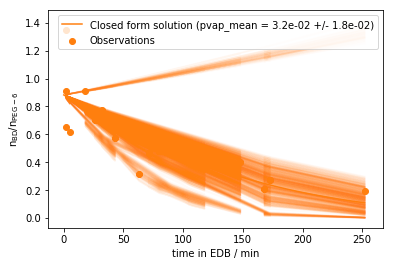

In [228]:
bd_hum = extractvp_bootstrap(df, p, 'bd_humid_model_params', 'bd_hg_humid', 'bd_humid', 'C1')

running 1000 simulations
simulation 0


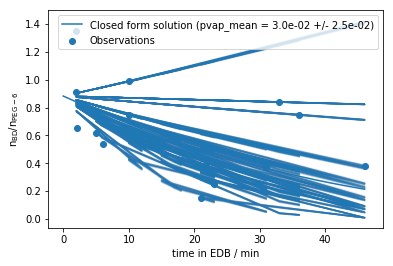

In [229]:
bd_hum = extractvp_bootstrap(df, p, 'bd_dry_model_params', 'bd_hg_dry', 'bd_dry', 'C0')